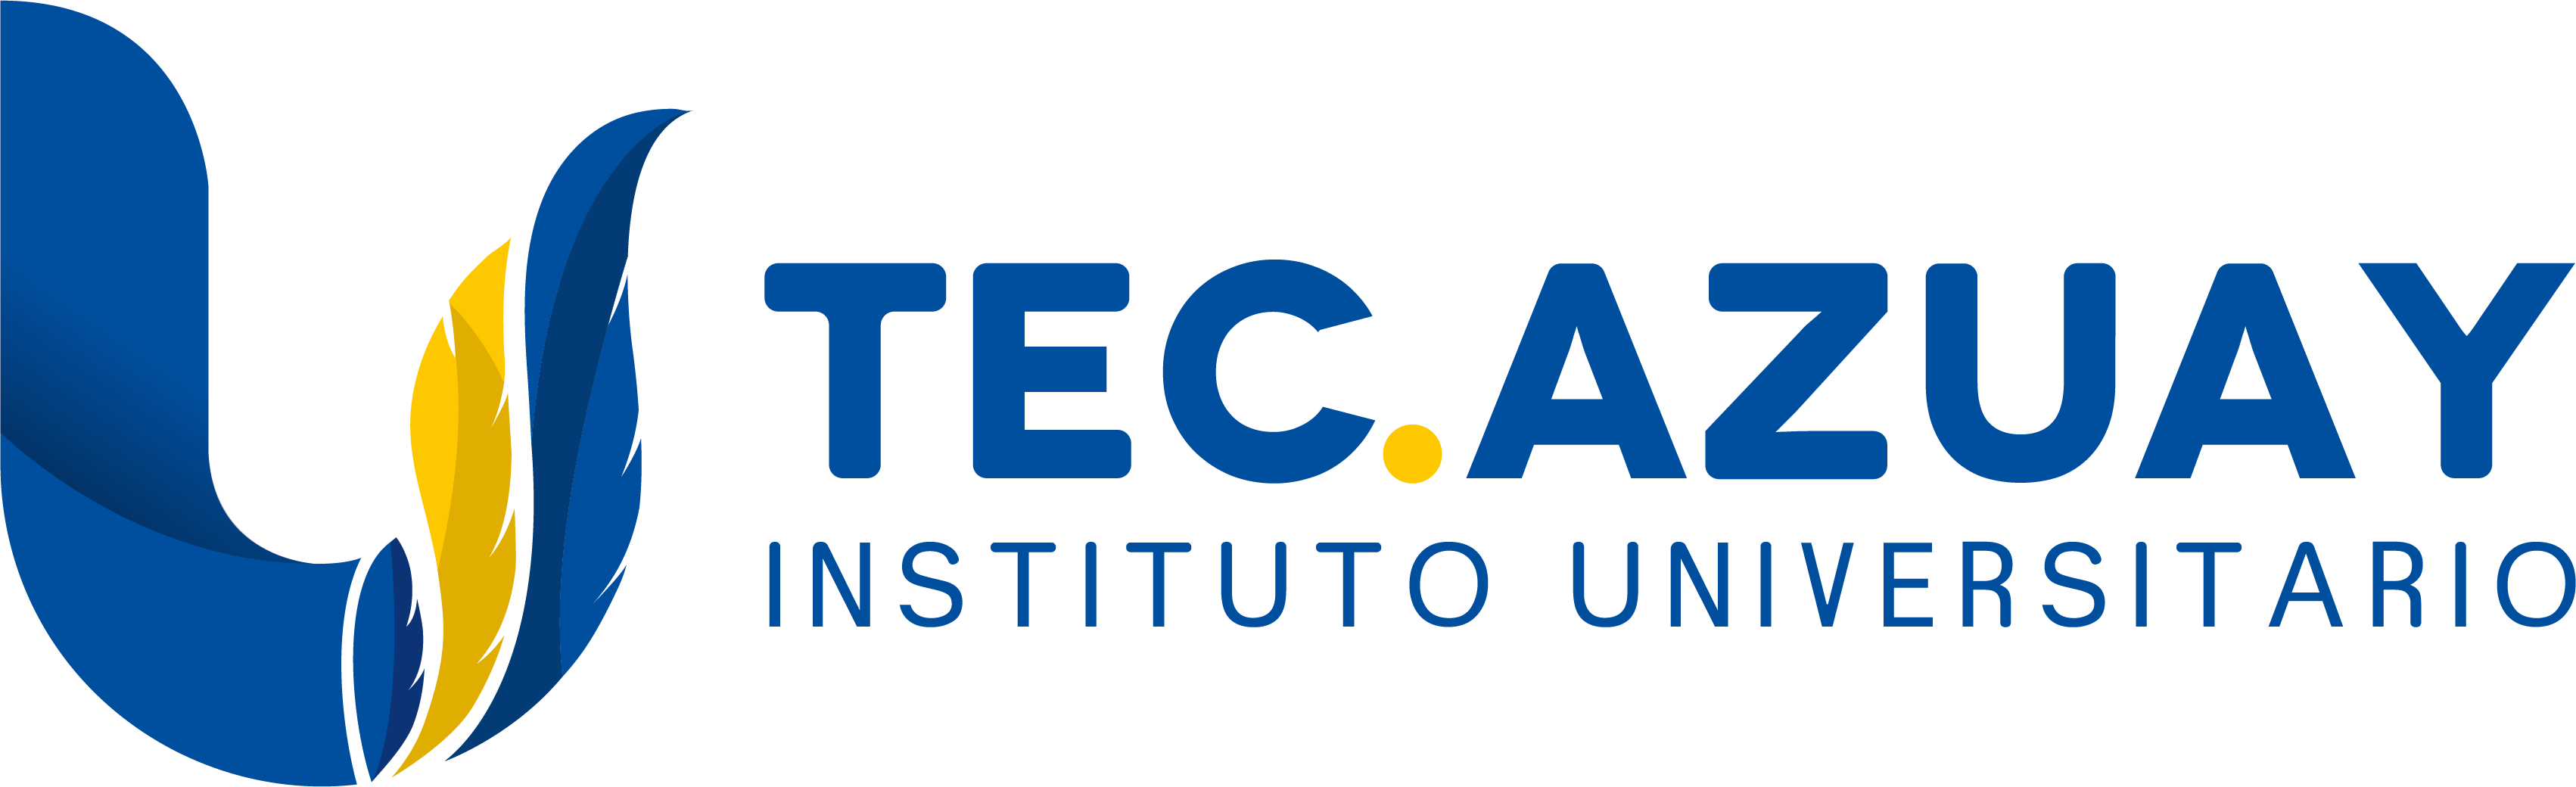

Asignatura: Mineria de datos

Nombre: Victro Cabrera

Docente: Ing. Veronica Chimbo


\# Clustering en el conjunto de datos con pyspark

## 1. Preparar los Datos

Primero, asegúrate de tener las bibliotecas necesarias:

In [1]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=9ab421fe902dbf0682ebbc82ad24698b965e845b213e5047c0798eec49d414c9
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [3]:
# Crear una sesión de Spark
spark = SparkSession.builder.appName("ClusteringExample").getOrCreate()

In [4]:
# Leer el archivo CSV
df = spark.read.csv('/content/MAESTRO DE NOTAS (1).csv', header=True, inferSchema=True)


In [5]:
# Verificar el esquema del DataFrame
df.printSchema()

root
 |-- Periodo: string (nullable = true)
 |-- Paralelo: string (nullable = true)
 |-- Identificacion: long (nullable = true)
 |-- Estudiante: string (nullable = true)
 |-- Carrera: string (nullable = true)
 |-- Nivel: string (nullable = true)
 |-- Asignatura: string (nullable = true)
 |-- Num_matricula: integer (nullable = true)
 |-- _c8: string (nullable = true)
 |-- Asistencia: double (nullable = true)
 |-- Nota final: double (nullable = true)
 |-- Estado: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- Estado Matrícula: string (nullable = true)
 |-- Tipo Ingreso: string (nullable = true)
 |-- Cédula docente: integer (nullable = true)
 |-- Nombre docente: string (nullable = true)



## 2. Preprocesar los Datos

Eliminamos columnas que contienen información sensible, para el proceso de aplicar k-means

In [6]:
df.columns

['Periodo',
 'Paralelo',
 'Identificacion',
 'Estudiante',
 'Carrera',
 'Nivel',
 'Asignatura',
 'Num_matricula',
 '_c8',
 'Asistencia',
 'Nota final',
 'Estado',
 '_c12',
 'Estado Matrícula',
 'Tipo Ingreso',
 'Cédula docente',
 'Nombre docente']

In [7]:
# Eliminar múltiples columnas
columns_to_drop = ['Estudiante', 'Identificacion', 'Nombre docente']
df = df.drop(*columns_to_drop)


Verificamos si se eliminaron correctamente las columnas, mostrando los nombres de columnas

In [8]:
# Mostrar el esquema del DataFrame después de eliminar las columnas
df.printSchema()

root
 |-- Periodo: string (nullable = true)
 |-- Paralelo: string (nullable = true)
 |-- Carrera: string (nullable = true)
 |-- Nivel: string (nullable = true)
 |-- Asignatura: string (nullable = true)
 |-- Num_matricula: integer (nullable = true)
 |-- _c8: string (nullable = true)
 |-- Asistencia: double (nullable = true)
 |-- Nota final: double (nullable = true)
 |-- Estado: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- Estado Matrícula: string (nullable = true)
 |-- Tipo Ingreso: string (nullable = true)
 |-- Cédula docente: integer (nullable = true)



Contar valores nulos por columna

In [9]:
from pyspark.sql.functions import col, sum

# Contar valores nulos por columna
missing_data = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_data.show()


+-------+--------+-------+-----+----------+-------------+----+----------+----------+------+----+----------------+------------+--------------+
|Periodo|Paralelo|Carrera|Nivel|Asignatura|Num_matricula| _c8|Asistencia|Nota final|Estado|_c12|Estado Matrícula|Tipo Ingreso|Cédula docente|
+-------+--------+-------+-----+----------+-------------+----+----------+----------+------+----+----------------+------------+--------------+
|      0|     202|      0|    0|         0|            0|6007|       231|       187|     0|6007|               0|           0|           202|
+-------+--------+-------+-----+----------+-------------+----+----------+----------+------+----+----------------+------------+--------------+



Codificar las columnas categóricas usando StringIndexer

In [10]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer

# Crear una instancia de SparkSession
spark = SparkSession.builder \
    .appName("StringIndexer Example") \
    .getOrCreate()

# Suponiendo que ya tienes tu DataFrame `df`
# Crear una lista de columnas categóricas que deseas codificar
categorical_columns = ['Asistencia', 'Nota final', 'Nivel', 'Tipo Ingreso', 'Carrera' ]

# Aplicar StringIndexer a cada columna categórica
for col_name in categorical_columns:
    indexer = StringIndexer(inputCol=col_name, outputCol=col_name + '_index')
    df = indexer.fit(df).transform(df)

# Mostrar el DataFrame resultante
df.show()


+-------+----------+--------------------+-------+--------------------+-------------+----+----------+----------+--------+----+----------------+------------+--------------+----------------+----------------+-----------+------------------+-------------+
|Periodo|  Paralelo|             Carrera|  Nivel|          Asignatura|Num_matricula| _c8|Asistencia|Nota final|  Estado|_c12|Estado Matrícula|Tipo Ingreso|Cédula docente|Asistencia_index|Nota final_index|Nivel_index|Tipo Ingreso_index|Carrera_index|
+-------+----------+--------------------+-------+--------------------+-------------+----+----------+----------+--------+----+----------------+------------+--------------+----------------+----------------+-----------+------------------+-------------+
|2023-2P|A_MATUTINA|SP R-TECNICO SUPE...|PRIMERO|SPR-114-COMUNICAC...|            1|NULL|     93.75|      8.59|APROBADO|NULL|        APROBADO|      NORMAL|     103002036|             1.0|            69.0|        0.0|               0.0|          0.0|


In [11]:
print(df.columns)


['Periodo', 'Paralelo', 'Carrera', 'Nivel', 'Asignatura', 'Num_matricula', '_c8', 'Asistencia', 'Nota final', 'Estado', '_c12', 'Estado Matrícula', 'Tipo Ingreso', 'Cédula docente', 'Asistencia_index', 'Nota final_index', 'Nivel_index', 'Tipo Ingreso_index', 'Carrera_index']


In [12]:
all_features = [
    'Asistencia', 'Nota final', 'Nivel_index', 'Tipo Ingreso_index', 'Carrera_index'
]
from pyspark.sql.functions import col

# Convertir las características a tipo double
df = df.select([col(f).cast("double") for f in all_features if f in df.columns])
df.printSchema()


root
 |-- Asistencia: double (nullable = true)
 |-- Nota final: double (nullable = true)
 |-- Nivel_index: double (nullable = false)
 |-- Tipo Ingreso_index: double (nullable = false)
 |-- Carrera_index: double (nullable = false)



Convertir las características a tipo double

In [26]:
from pyspark.ml.feature import Imputer

# Imputar valores nulos en las columnas numéricas
imputer = Imputer(inputCols=numeric_features, outputCols=numeric_features)
df = imputer.fit(df).transform(df)

# Convertir las características a tipo double
df = df.select([col(f).cast("double") for f in all_features])

# Mostrar el esquema y algunas filas del DataFrame final
df.printSchema()
df.show()


root
 |-- Asistencia: double (nullable = false)
 |-- Nota final: double (nullable = false)
 |-- Carrera_index: double (nullable = false)
 |-- Nivel_index: double (nullable = false)
 |-- Tipo Ingreso_index: double (nullable = false)

+----------+----------+-------------+-----------+------------------+
|Asistencia|Nota final|Carrera_index|Nivel_index|Tipo Ingreso_index|
+----------+----------+-------------+-----------+------------------+
|     93.75|      8.59|          0.0|        0.0|               0.0|
|     100.0|      8.88|          0.0|        0.0|               0.0|
|     100.0|       9.3|          0.0|        0.0|               0.0|
|     100.0|      10.0|          0.0|        0.0|               0.0|
|     100.0|       9.2|          0.0|        0.0|               0.0|
|     100.0|      8.25|          0.0|        0.0|               0.0|
|     100.0|       8.9|          0.0|        0.0|               0.0|
|     100.0|       9.2|          0.0|        0.0|               0.0|
|      8

In [14]:
# Reemplazar valores nulos en las columnas especificadas con 0
df = df.fillna({
    'Asistencia': 0.0,
    'Nota final': 0.0,
    'Nivel_index': 0.0,
    'Tipo Ingreso_index': 0.0,
    'Carrera_index': 0.0
})

# Mostrar el DataFrame resultante
df.show()


+----------+----------+-----------+------------------+-------------+
|Asistencia|Nota final|Nivel_index|Tipo Ingreso_index|Carrera_index|
+----------+----------+-----------+------------------+-------------+
|     93.75|      8.59|        0.0|               0.0|          0.0|
|     100.0|      8.88|        0.0|               0.0|          0.0|
|     100.0|       9.3|        0.0|               0.0|          0.0|
|     100.0|      10.0|        0.0|               0.0|          0.0|
|     100.0|       9.2|        0.0|               0.0|          0.0|
|     100.0|      8.25|        0.0|               0.0|          0.0|
|     100.0|       8.9|        0.0|               0.0|          0.0|
|     100.0|       9.2|        0.0|               0.0|          0.0|
|      87.5|      8.44|        0.0|               0.0|          0.0|
|     100.0|      8.82|        0.0|               0.0|          2.0|
|     96.03|       7.3|        4.0|               0.0|          1.0|
|     97.61|      7.14|        4.0

In [15]:
# Contar valores nulos por columna
missing_data = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
missing_data.show()

+----------+----------+-----------+------------------+-------------+
|Asistencia|Nota final|Nivel_index|Tipo Ingreso_index|Carrera_index|
+----------+----------+-----------+------------------+-------------+
|         0|         0|          0|                 0|            0|
+----------+----------+-----------+------------------+-------------+



Seleccionaremos características relevantes para el clustering y escalaremos los datos:

In [16]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.sql.functions import col, mean
from pyspark.ml.feature import StringIndexer


In [17]:
print(df.columns)


['Asistencia', 'Nota final', 'Nivel_index', 'Tipo Ingreso_index', 'Carrera_index']


In [18]:
from pyspark.sql.functions import col
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

# Definir las columnas categóricas y numéricas
categorical_features = ['Carrera', 'Nivel', 'Tipo Ingreso']
numeric_features = ['Asistencia', 'Nota final']

# Codificar las columnas categóricas usando StringIndexer
indexers = [StringIndexer(inputCol=feature, outputCol=f"{feature}_index") for feature in categorical_features]

# Lista de columnas después de la codificación
indexed_features = [f"{feature}_index" for feature in categorical_features]

# Seleccionar las características relevantes
all_features = numeric_features + indexed_features

# Ensamblar las características en una sola columna "features"
assembler = VectorAssembler(inputCols=all_features, outputCol="features")
df_assembled = assembler.transform(df)

# Escalar las características
scaler = StandardScaler(inputCol="features", outputCol="scaled_features", withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled = scaler_model.transform(df_assembled)

# Mostrar el esquema y algunas filas del DataFrame final
df_scaled.printSchema()
df_scaled.show()


root
 |-- Asistencia: double (nullable = false)
 |-- Nota final: double (nullable = false)
 |-- Nivel_index: double (nullable = false)
 |-- Tipo Ingreso_index: double (nullable = false)
 |-- Carrera_index: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)

+----------+----------+-----------+------------------+-------------+--------------------+--------------------+
|Asistencia|Nota final|Nivel_index|Tipo Ingreso_index|Carrera_index|            features|     scaled_features|
+----------+----------+-----------+------------------+-------------+--------------------+--------------------+
|     93.75|      8.59|        0.0|               0.0|          0.0|(5,[0,1],[93.75,8...|[0.18355437022472...|
|     100.0|      8.88|        0.0|               0.0|          0.0|(5,[0,1],[100.0,8...|[0.43844252892806...|
|     100.0|       9.3|        0.0|               0.0|          0.0|(5,[0,1],[100.0,9...|[0.43844252892806...|
|     100.0|  

## 3. Aplicar K-Means

Definimos el número de clusters y aplicamos el algoritmo K-Means:

In [20]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler

# Definir el número de clusters
k = 6

# Aplicar KMeans
kmeans = KMeans(k=k, seed=0, featuresCol="scaled_features", predictionCol="Cluster")
model = kmeans.fit(df_scaled)
df_clusters = model.transform(df_scaled)

# Mostrar el esquema y algunas filas del DataFrame con clusters
df_clusters.printSchema()
df_clusters.show()


root
 |-- Asistencia: double (nullable = false)
 |-- Nota final: double (nullable = false)
 |-- Nivel_index: double (nullable = false)
 |-- Tipo Ingreso_index: double (nullable = false)
 |-- Carrera_index: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- scaled_features: vector (nullable = true)
 |-- Cluster: integer (nullable = false)

+----------+----------+-----------+------------------+-------------+--------------------+--------------------+-------+
|Asistencia|Nota final|Nivel_index|Tipo Ingreso_index|Carrera_index|            features|     scaled_features|Cluster|
+----------+----------+-----------+------------------+-------------+--------------------+--------------------+-------+
|     93.75|      8.59|        0.0|               0.0|          0.0|(5,[0,1],[93.75,8...|[0.18355437022472...|      0|
|     100.0|      8.88|        0.0|               0.0|          0.0|(5,[0,1],[100.0,8...|[0.43844252892806...|      0|
|     100.0|       9.3|        0.0|         

In [21]:
from pyspark.sql import functions as F

# Agregar una columna 'Index' al DataFrame original
df = df.withColumn("Index", F.monotonically_increasing_id())

# Solo asegúrate de añadir la columna 'Index' en `df_clusters` antes de la unión

df_clusters = df_clusters.withColumn("Index", F.monotonically_increasing_id())

# Unir el DataFrame original con el DataFrame de clusters usando la columna 'Index'
df_final = df.join(df_clusters.select("Index", "Cluster"), on="Index", how="left").drop("Index")

# Mostrar el esquema y algunas filas del DataFrame final con clusters
df_final.printSchema()
df_final.show()


root
 |-- Asistencia: double (nullable = false)
 |-- Nota final: double (nullable = false)
 |-- Nivel_index: double (nullable = false)
 |-- Tipo Ingreso_index: double (nullable = false)
 |-- Carrera_index: double (nullable = false)
 |-- Cluster: integer (nullable = true)

+----------+----------+-----------+------------------+-------------+-------+
|Asistencia|Nota final|Nivel_index|Tipo Ingreso_index|Carrera_index|Cluster|
+----------+----------+-----------+------------------+-------------+-------+
|     93.75|      8.59|        0.0|               0.0|          0.0|      0|
|     100.0|      8.88|        0.0|               0.0|          0.0|      0|
|     100.0|       9.3|        0.0|               0.0|          0.0|      0|
|     100.0|      10.0|        0.0|               0.0|          0.0|      0|
|     100.0|       9.2|        0.0|               0.0|          0.0|      0|
|     100.0|      8.25|        0.0|               0.0|          0.0|      0|
|     100.0|       8.9|        0.0

In [22]:
df_final.printSchema()
df_final.show(5)  # Mostrar algunas filas para verificar la columna 'Cluster'


root
 |-- Asistencia: double (nullable = false)
 |-- Nota final: double (nullable = false)
 |-- Nivel_index: double (nullable = false)
 |-- Tipo Ingreso_index: double (nullable = false)
 |-- Carrera_index: double (nullable = false)
 |-- Cluster: integer (nullable = true)

+----------+----------+-----------+------------------+-------------+-------+
|Asistencia|Nota final|Nivel_index|Tipo Ingreso_index|Carrera_index|Cluster|
+----------+----------+-----------+------------------+-------------+-------+
|     93.75|      8.59|        0.0|               0.0|          0.0|      0|
|     100.0|      8.88|        0.0|               0.0|          0.0|      0|
|     100.0|       9.3|        0.0|               0.0|          0.0|      0|
|     100.0|      10.0|        0.0|               0.0|          0.0|      0|
|     100.0|       9.2|        0.0|               0.0|          0.0|      0|
+----------+----------+-----------+------------------+-------------+-------+
only showing top 5 rows



## 4. Visualizar los Resultados del Clustering

Podemos visualizar los resultados del clustering en un gráfico 2D usando dos de las características:

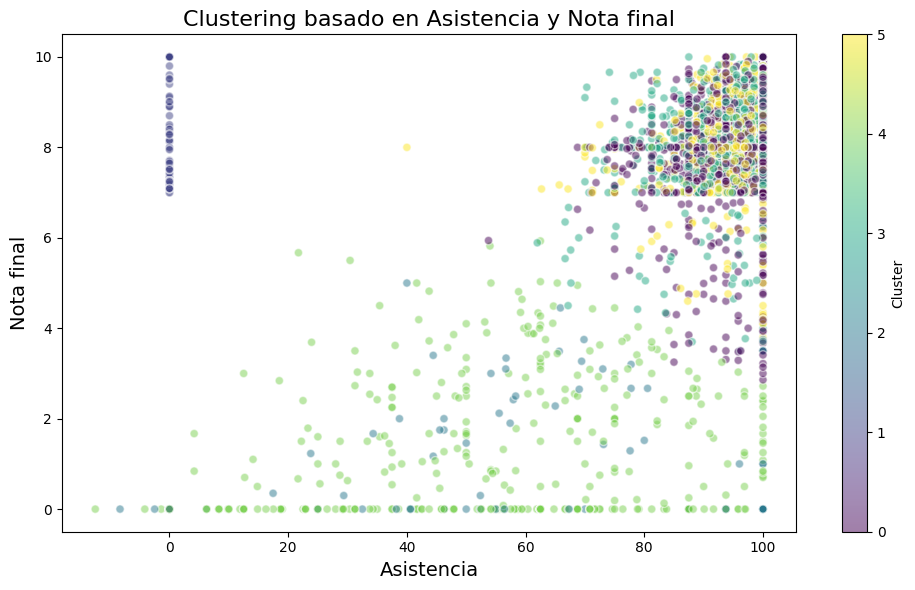

In [23]:
import matplotlib.pyplot as plt

# Convertir el DataFrame de PySpark a pandas
df_pandas = df_clusters.toPandas()

# Crear la visualización
plt.figure(figsize=(10, 6))
plt.scatter(df_pandas['Asistencia'], df_pandas['Nota final'], c=df_pandas['Cluster'], cmap='viridis', alpha=0.5, edgecolors='w')
plt.title("Clustering basado en Asistencia y Nota final", fontsize=16)
plt.xlabel("Asistencia", fontsize=14)
plt.ylabel("Nota final", fontsize=14)
plt.colorbar(label='Cluster')
plt.tight_layout()
plt.show()


## 5. Análisis de Resultados de Clustering

Ahora puedes analizar cada cluster:

In [24]:
print(df.columns)


['Asistencia', 'Nota final', 'Nivel_index', 'Tipo Ingreso_index', 'Carrera_index', 'Index']


In [25]:
from pyspark.sql import functions as F

# Agrupar por 'Cluster' y calcular estadísticas agregadas
cluster_summary = df_final.groupBy('Cluster').agg(
    F.mean('Asistencia').alias('mean_Asistencia'),
    F.mean('Nota final').alias('mean_Nota_final'),
    F.first('Carrera_index').alias('most_frequent_Carrera_index'),
    F.first('Nivel_index').alias('most_frequent_Nivel_index'),
    F.first('Tipo Ingreso_index').alias('most_frequent_Tipo_Ingreso_index')
)

# Mostrar el esquema y algunas filas del resumen
cluster_summary.printSchema()
cluster_summary.show()


root
 |-- Cluster: integer (nullable = true)
 |-- mean_Asistencia: double (nullable = true)
 |-- mean_Nota_final: double (nullable = true)
 |-- most_frequent_Carrera_index: double (nullable = true)
 |-- most_frequent_Nivel_index: double (nullable = true)
 |-- most_frequent_Tipo_Ingreso_index: double (nullable = true)

+-------+-----------------+------------------+---------------------------+-------------------------+--------------------------------+
|Cluster|  mean_Asistencia|   mean_Nota_final|most_frequent_Carrera_index|most_frequent_Nivel_index|most_frequent_Tipo_Ingreso_index|
+-------+-----------------+------------------+---------------------------+-------------------------+--------------------------------+
|      1|              0.0|3.0572139303482593|                       11.0|                      0.0|                             1.0|
|      3|96.88747578347565| 8.488188034188035|                       11.0|                      1.0|                             0.0|
|      5|9